1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Median Filter:
  PSNR: 26.3359, SSIM: 0.5819, MSE: 0.002325

Wavelet Denoising:
  PSNR: 27.5073, SSIM: 0.7095, MSE: 0.001775

Simulated Noise2Void:
  PSNR: 24.6634, SSIM: 0.6610, MSE: 0.003417



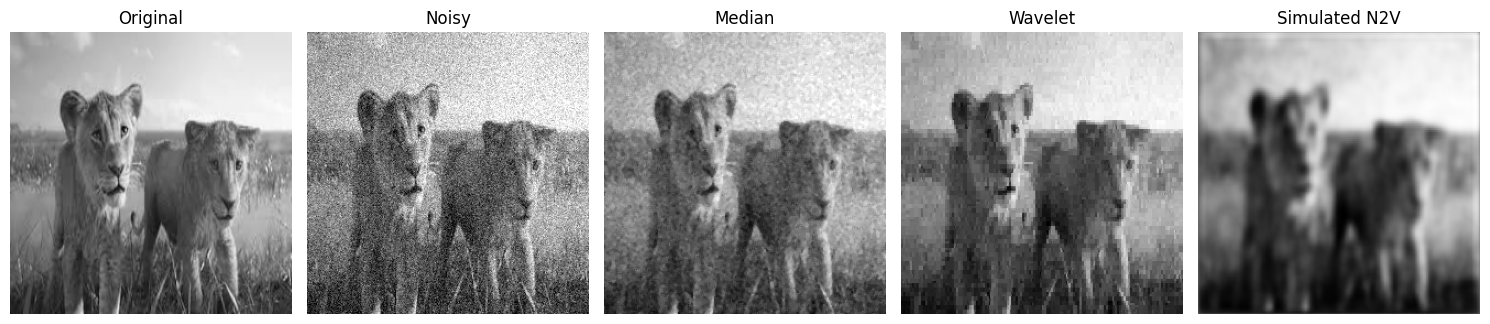

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration, metrics, img_as_float
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# STEP 3: Load and Preprocess Image
image = cv2.imread('image.jpeg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))
image = img_as_float(image)

# Add synthetic Gaussian noise
noisy_image = image + 0.1 * np.random.normal(loc=0, scale=1, size=image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

# STEP 4: Denoising Techniques

## 1. Median Filter
median_denoised = cv2.medianBlur((noisy_image * 255).astype(np.uint8), 3) / 255.0

## 2. Wavelet Denoising
wavelet_denoised = restoration.denoise_wavelet(noisy_image, method='BayesShrink', mode='soft', rescale_sigma=True)

## 3. Simulated Noise2Void using Autoencoder
# Prepare data for training
X = noisy_image.reshape(1, 256, 256, 1)
y = image.reshape(1, 256, 256, 1)

# Build autoencoder
inp = Input(shape=(256, 256, 1))
x = Conv2D(64, (3,3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer='adam', loss='mse')

# Train on single image (simulate Noise2Void)
autoencoder.fit(X, y, epochs=50, verbose=0)

# Predict denoised image
n2v_denoised = autoencoder.predict(X)[0,...,0]

# STEP 5: Evaluate
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

def evaluate(original, denoised):
    psnr = peak_signal_noise_ratio(original, denoised, data_range=1.0)
    ssim = structural_similarity(original, denoised, data_range=1.0)
    mse = mean_squared_error(original, denoised)
    return psnr, ssim, mse


results = {
    "Median Filter": evaluate(image, median_denoised),
    "Wavelet Denoising": evaluate(image, wavelet_denoised),
    "Simulated Noise2Void": evaluate(image, n2v_denoised),
}

# Display metrics
for method, (psnr, ssim, mse) in results.items():
    print(f"{method}:\n  PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, MSE: {mse:.6f}\n")

# STEP 6: Show Visual Comparison
titles = ['Original', 'Noisy', 'Median', 'Wavelet', 'Simulated N2V']
images = [image, noisy_image, median_denoised, wavelet_denoised, n2v_denoised]

plt.figure(figsize=(15, 6))
for i in range(len(images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [2]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.7 MB/s eta 0:00:00
